# Tutorial Content


This notebook will walk you through steps to read in and organize velocity data in a raster format using xarray and rioxarray tools

First, lets install the python libraries that were listed on the [Software](software.ipynb) page:

# new notebook structure (still working on)**

- brief description of notebook at top (section 1)
- raster datastream 1, ITS_LIVE geotiff ingesting and organizing (section 2)
    - look at dims, vars, crs etc
- raster datastream 2, ITS_IVE netcdf ingesting and organizing (section 3)
    - look at dims, vars, crs etc
- read in vector data (section 4)
- working with projections (section 5)
    - raster datasets have different projections (UTM and Asia_North_Lambert_Conformal_Conic)
    - should i put them into same CRS or have a different projected geodataframe of glaciers for each velocity ds, and totally separate workflows...?
        - if same crs, which prefereable btw UTM and asia norht lambert conformal conic
- once both raster types are in workable formats, start on reading in vectors etc (section 6...)


In [1]:
import geopandas as gpd
import os
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
from geocube.api.core import make_geocube

In [2]:
!pwd

/Users/emarshall/Desktop/siparcs/xr_book1/mynewbook


In [3]:
gen_path = '/Users/emarshall/Desktop/siparcs/xr_book1/'

## Raster datastream 1: ITS_LIVE (Geotiff)

This section contains a workflow for reading in and organizing ITS_LIVE glacier velocity data that is accessed in geotiff format from S3

The velocity data we are using is broken into individual velocity components. That means that for the same spatial footprint, we have a file containing ice movement in the x direction and a file containing ice movement in the y direction. We need information from both of these files so we write a function to bring both files into the jupyter notebook, then organize them so that we can see the movement of ice in both the x and y directions as well as the magnitude of the ice velocity (speed). 



In [4]:
def components_to_speed(vx_path, vy_path):
    '''this function reads in x,y components of velocity, generates speed variable. return xarray
    dataset w/ x,y, speed variables. function will break if vx,vy objects don"t have same x,y coords'''
    
    vy_da = rxr.open_rasterio(vy_path, masked=False).squeeze()
    vx_da = rxr.open_rasterio(vx_path, masked=False).squeeze()
    
    ds_gen = xr.Dataset()
    ds_gen['vx'] = vx_da
    ds_gen['vy'] = vy_da
    sp = np.sqrt((ds_gen['vx'].data**2) + ds_gen['vy'].data**2)
    ds_gen['sp'] = (['x','y'], sp.T)
    
    return ds_gen

Let's break down what exactly the above function is doing:

First, we see that it takes two inputs: vx_path and vy_path. These paths point to where on our computer the different files are stored. 

In the first two lines of the function we use rioxarray to read in the x- and the y-component files as **xarray.DataArrays**

After that, we initialize a new object, *ds_gen*, which is a **xarray.DataSet**. We then add a variable to ds_gen called 'vx' and assign the vx_da object to that variable. We do the same for vx_da. Now, we have made a dataset that is composed of the two data arrays that we read in from file. 

We are also interested in speed, so we take the equation for computing magnitude of velocity and add a third variable (DataArray) to our Dataset. 

This will add a variable defined by the equation:

            vv = (vx^2 + vy^2)^1/2

Let's execute the function and take a look at the object it returns

First, define the inputs to your function. These are the paths to the x and the y data on your computer:

In [5]:
n45_vy_path = gen_path + 'mynewbook/gardner_data/N45_0240m_vy.tiff'
n45_vx_path = gen_path + 'mynewbook/gardner_data/N45_0240m_vx.tiff'


And run the function: 

In [6]:
ds_45n = components_to_speed(n45_vx_path, n45_vy_path)


In [7]:
ds_45n

<xarray.Dataset>
Dimensions:      (x: 4440, y: 27072)
Coordinates:
    band         int64 1
  * x            (x) float64 -3.253e+04 -3.229e+04 ... 1.033e+06 1.033e+06
  * y            (y) float64 6.297e+06 6.297e+06 ... -1.993e+05 -1.996e+05
    spatial_ref  int64 0
Data variables:
    vx           (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    vy           (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    sp           (x, y) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan

In [8]:
type(ds_45n)


xarray.core.dataset.Dataset

What is the CRS of this object?

In [9]:
ds_45n.spatial_ref.attrs

{'crs_wkt': 'PROJCS["WGS 84 / UTM zone 45N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",87],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32645"]]',
 'semi_major_axis': 6378137.0,
 'semi_minor_axis': 6356752.314245179,
 'inverse_flattening': 298.257223563,
 'reference_ellipsoid_name': 'WGS 84',
 'longitude_of_prime_meridian': 0.0,
 'prime_meridian_name': 'Greenwich',
 'geographic_crs_name': 'WGS 84',
 'horizontal_datum_name': 'World Geodetic System 1984',
 'projected_crs_name': 'WGS 84 / UTM zone 45N',
 'grid_mapping_name': 'trans

In [10]:
print(ds_45n.dims)
print('---')
print(ds_45n.coords)
print('---')
print(ds_45n.variables)
print('---')
print(ds_45n.attrs)

Frozen({'x': 4440, 'y': 27072})
---
Coordinates:
    band         int64 1
  * x            (x) float64 -3.253e+04 -3.229e+04 ... 1.033e+06 1.033e+06
  * y            (y) float64 6.297e+06 6.297e+06 ... -1.993e+05 -1.996e+05
    spatial_ref  int64 0
---
Frozen({'band': <xarray.Variable ()>
array(1), 'x': <xarray.IndexVariable 'x' (x: 4440)>
array([ -32527.5,  -32287.5,  -32047.5, ..., 1032352.5, 1032592.5, 1032832.5]), 'y': <xarray.IndexVariable 'y' (y: 27072)>
array([6297487.5, 6297247.5, 6297007.5, ..., -199072.5, -199312.5, -199552.5]), 'spatial_ref': <xarray.Variable ()>
array(0)
Attributes:
    crs_wkt:                           PROJCS["WGS 84 / UTM zone 45N",GEOGCS[...
    semi_major_axis:                   6378137.0
    semi_minor_axis:                   6356752.314245179
    inverse_flattening:                298.257223563
    reference_ellipsoid_name:          WGS 84
    longitude_of_prime_meridian:       0.0
    prime_meridian_name:               Greenwich
    geographic_crs_n

## Raster datastream 2: ITS_LIVE (netcdf)

This section contains a workflow for reading in and organizing ITS_LIVE glacier velocity data that is accessed in netcdf format from the NSIDC DAAC. Whereas before, we needed to build a the magnitude of velocity variable from the velocity component variables (individual geotiff files), the netcdf file contains a variable for magnitude of velocity as well as many other variables representing land cover types, error estimates and metadata

In [11]:
itslive = rxr.open_rasterio(gen_path[:-9] + '/data/HMA_G0120_0000.nc').squeeze()

In [12]:
itslive

<xarray.Dataset>
Dimensions:         (y: 15904, x: 23440)
Coordinates:
  * y               (y) float64 1.643e+06 1.643e+06 ... -2.648e+05 -2.649e+05
  * x               (x) float64 -2.16e+06 -2.16e+06 ... 6.526e+05 6.527e+05
    band            int64 1
    UTM_Projection  int64 0
Data variables: (12/13)
    vx              (y, x) float32 ...
    chip_size_max   (y, x) uint16 ...
    ocean           (y, x) uint8 ...
    rock            (y, x) uint8 ...
    ice             (y, x) uint8 ...
    vy              (y, x) float32 ...
    ...              ...
    vx_err          (y, x) float32 ...
    vy_err          (y, x) float32 ...
    v_err           (y, x) float32 ...
    date            (y, x) float32 ...
    dt              (y, x) uint16 ...
    count           (y, x) uint16 ...
Attributes:
    author:                   Alex S. Gardner, JPL/NASA
    date_created:             08-May-2019 13:31:28
    GDAL_AREA_OR_POINT:       Area
    institution:              NASA Jet Propulsion Laboratory (JPL), Californi...
    motion_coordinates:       map
    motion_detection_method:  feature
    scene_pair_type:          optical
    title:                    autoRIFT surface velocities

What is the CRS of this object?

There are two ways we can check that. First, by using the `rio.crs` accessor:

In [13]:
itslive.rio.crs

CRS.from_wkt('PROJCS["Asia_North_Lambert_Conformal_Conic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["false_easting",0],PARAMETER["false_northing",0],PARAMETER["central_meridian",95],PARAMETER["standard_parallel_1",15],PARAMETER["standard_parallel_2",65],PARAMETER["latitude_of_origin",30],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","102027"]]')

The netcdf object is in a different CRS than the geotiff object. Because **Asia North Lambert Conformal Conic** covers a larger spatial extent than a single UTM zone (the projection of the geotiff object), we will use that projection.
*add link to good explainer page?*

In [14]:
itslive.dims

Frozen({'y': 15904, 'x': 23440})

In [15]:
itslive.coords

Coordinates:
  * y               (y) float64 1.643e+06 1.643e+06 ... -2.648e+05 -2.649e+05
  * x               (x) float64 -2.16e+06 -2.16e+06 ... 6.526e+05 6.527e+05
    band            int64 1
    UTM_Projection  int64 0

## Vector data 

In [16]:
#read in vector data 
se_asia = gpd.read_file(gen_path[:-9] + 'data/nsidc0770_15.rgi60.SouthAsiaEast/15_rgi60_SouthAsiaEast.shp')

How many glaciers are in this dataframe?

In [17]:
len(se_asia['RGIId'])

13119

What coordinate reference system is this dataframe in? 

In [18]:
se_asia.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The vector dataset is in WGS 84, meaning that its coordinates are in degrees latitude and longitude rather than meters N and E. We will project this dataset to match the projection of the netcdf dataset.

## Handling projections

Let's project this dataframe to match the CRS of the itslive dataset

In [31]:
#not sure why but this didn't work for me specifying epsg code, had to specify full description
se_asia_prj = se_asia.to_crs('+proj=lcc +lat_1=15 +lat_2=65 +lat_0=30 +lon_0=95 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m no_defs')
se_asia_prj

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-15.00001,G102044E29941N,19990920,-9999999,102.044042,29.941000,15,3,0.438,4996,...,251,850,0,0,0,0,9,9,None,"POLYGON ((626747.322 19334.286, 626747.214 193..."
1,RGI60-15.00002,G102042E29987N,19990920,-9999999,102.042346,29.987019,15,3,0.644,4947,...,244,1021,0,0,0,0,9,9,None,"POLYGON ((626699.144 24673.098, 626701.110 246..."
2,RGI60-15.00003,G102041E29997N,19990920,-9999999,102.041130,29.997311,15,3,0.225,5019,...,274,812,0,0,0,0,9,9,None,"POLYGON ((626205.858 25396.784, 626210.489 254..."
3,RGI60-15.00004,G102050E29962N,19990920,-9999999,102.050283,29.962297,15,3,0.985,4622,...,52,2318,0,0,0,0,9,9,None,"POLYGON ((627054.150 21582.052, 627057.905 216..."
4,RGI60-15.00005,G102044E30025N,19990920,-9999999,102.043728,30.025101,15,3,0.465,4733,...,20,913,0,0,0,0,9,9,None,"POLYGON ((626913.162 28267.766, 626895.820 282..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13114,RGI60-15.13115,G081977E30337N,20090918,-9999999,81.977000,30.337000,15,1,1.356,5480,...,352,1856,0,0,0,0,9,9,CN5Z342A0003,"POLYGON ((-1150121.533 121963.660, -1150118.27..."
13115,RGI60-15.13116,G081991E30339N,20090918,-9999999,81.991000,30.339000,15,1,7.427,5266,...,330,5779,0,0,0,0,9,9,CN5Z342A0003,"POLYGON ((-1148353.222 121707.808, -1148328.34..."
13116,RGI60-15.13117,G081355E30440N,20070912,-9999999,81.355000,30.440000,15,1,6.788,5696,...,96,5519,0,0,0,0,9,9,CN5Z342B0006,"POLYGON ((-1204224.276 142125.331, -1204220.83..."
13117,RGI60-15.13118,G081361E30451N,20070912,-9999999,81.361000,30.451000,15,1,0.043,5969,...,206,527,0,0,0,0,9,9,None,"POLYGON ((-1202593.561 141849.818, -1202579.07..."


In [63]:
se_asia_prj['RGI_int'] = se_asia_prj['RGIId'].str.slice(9,).replace('.','_')
se_asia_prj['RGI_int'] = se_asia_prj.RGI_int.apply(lambda x: '15' + x)
se_asia_prj

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,Integer_ID,RGI_int
0,RGI60-15.00001,G102044E29941N,19990920,-9999999,102.044042,29.941000,15,3,0.438,4996,...,0,0,0,0,9,9,None,"POLYGON ((626747.322 19334.286, 626747.214 193...",0,1500001
1,RGI60-15.00002,G102042E29987N,19990920,-9999999,102.042346,29.987019,15,3,0.644,4947,...,0,0,0,0,9,9,None,"POLYGON ((626699.144 24673.098, 626701.110 246...",1,1500002
2,RGI60-15.00003,G102041E29997N,19990920,-9999999,102.041130,29.997311,15,3,0.225,5019,...,0,0,0,0,9,9,None,"POLYGON ((626205.858 25396.784, 626210.489 254...",2,1500003
3,RGI60-15.00004,G102050E29962N,19990920,-9999999,102.050283,29.962297,15,3,0.985,4622,...,0,0,0,0,9,9,None,"POLYGON ((627054.150 21582.052, 627057.905 216...",3,1500004
4,RGI60-15.00005,G102044E30025N,19990920,-9999999,102.043728,30.025101,15,3,0.465,4733,...,0,0,0,0,9,9,None,"POLYGON ((626913.162 28267.766, 626895.820 282...",4,1500005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13114,RGI60-15.13115,G081977E30337N,20090918,-9999999,81.977000,30.337000,15,1,1.356,5480,...,0,0,0,0,9,9,CN5Z342A0003,"POLYGON ((-1150121.533 121963.660, -1150118.27...",13114,1513115
13115,RGI60-15.13116,G081991E30339N,20090918,-9999999,81.991000,30.339000,15,1,7.427,5266,...,0,0,0,0,9,9,CN5Z342A0003,"POLYGON ((-1148353.222 121707.808, -1148328.34...",13115,1513116
13116,RGI60-15.13117,G081355E30440N,20070912,-9999999,81.355000,30.440000,15,1,6.788,5696,...,0,0,0,0,9,9,CN5Z342B0006,"POLYGON ((-1204224.276 142125.331, -1204220.83...",13116,1513117
13117,RGI60-15.13118,G081361E30451N,20070912,-9999999,81.361000,30.451000,15,1,0.043,5969,...,0,0,0,0,9,9,None,"POLYGON ((-1202593.561 141849.818, -1202579.07...",13117,1513118


In [82]:
se_asia_prj.loc[se_asia_prj['Area'] > 5.]['RGI_int']

185        185
233        233
367        367
405        405
502        502
         ...  
13043    13043
13064    13064
13103    13103
13115    13115
13116    13116
Name: RGI_int, Length: 524, dtype: int64

In [90]:
def rasterize_vector(gpdf_prj, raster_obj): 
    
    #read in gpdf from shp file
    #gpdf = gpd.read_file(vector_path)
    #project to local utm
    #gpdf_utm = gpdf.to_crs(f'EPSG:{utm_code}')
    #use index as a unique key for each glacier
    gpdf_sub = gpdf_prj.loc[gpdf_prj['Area'] > 5.]
    gpdf_sub['RGI_int'] = gpdf_sub.index.astype(int) # RGI_int corresponds to RGI ID but in int form ie 15.00001 = 1500001
    #print(gpdf_utm['Integer_ID'])
    
    #rasterize glacier vector by unique id 

    out_grid = make_geocube(
            vector_data = gpdf_sub,
            measurements = ['RGI_int'],
            like = raster_obj['v'] #need to specify a var here, not sure best way to do that
            )
    
    #now merge the rasterized vector and the original raster togehter into a geocube
    out_grid['speed'] = (raster_obj.dims, raster_obj.v.values, raster_obj.attrs, raster_obj.encoding)
    
    #now, get velocity statistics of each 'region' (integer) using the mask
    #grouped_ID = out_grid.drop('spatial_ref').groupby(out_grid.Integer_ID)

    #compute zonal stats groupedd by ID
    #grid_mean_sp = grouped_ID.mean().rename({'speed': 'speed_mean'})
    #grid_min_sp = grouped_ID.min().rename({'speed': 'speed_min'})
    #grid_max_sp = grouped_ID.max().rename({'speed': 'speed_max'})
    #grid_std_sp = grouped_ID.max().rename({'speed': 'speed_std'})
    
    #merge each zonal stat xr obj into a single xr obj, convert to pandas df
    #zonal_stats = xr.merge([grid_mean_sp, grid_min_sp, grid_max_sp, grid_std_sp]).to_dataframe()
    #zonal_stats = zonal_stats.reset_index()
    
   # return zonal_stats
    return out_grid

In [91]:
rasterize_vector_seasia = rasterize_vector(se_asia_prj, itslive)
rasterize_vector_seasia

/Users/emarshall/miniconda3/envs/mynewbook/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<xarray.Dataset>
Dimensions:      (y: 15904, x: 23440)
Coordinates:
  * y            (y) float64 1.643e+06 1.643e+06 ... -2.648e+05 -2.649e+05
  * x            (x) float64 -2.16e+06 -2.16e+06 ... 6.526e+05 6.527e+05
    spatial_ref  int64 0
Data variables:
    RGI_int      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    speed        (y, x) float32 -3.277e+04 -3.277e+04 ... -3.277e+04 -3.277e+04

In [93]:
np.count_nonzero(~np.isnan(rasterize_vector_seasia.RGI_int))

420829

In [94]:
#now, get velocity statistics of each 'region' (integer) using the mask
grouped_ID = rasterize_vector_seasia.drop('spatial_ref').groupby(rasterize_vector_seasia.RGI_int)


In [95]:
#compute zonal stats groupedd by ID
grid_mean_sp = grouped_ID.mean().rename({'speed': 'speed_mean'})
grid_min_sp = grouped_ID.min().rename({'speed': 'speed_min'})
grid_max_sp = grouped_ID.max().rename({'speed': 'speed_max'})
grid_std_sp = grouped_ID.max().rename({'speed': 'speed_std'})
   

In [96]:
#merge each zonal stat xr obj into a single xr obj, convert to pandas df
zonal_stats = xr.merge([grid_mean_sp, grid_min_sp, grid_max_sp, grid_std_sp]).to_dataframe()
zonal_stats = zonal_stats.reset_index()
    
zonal_stats

,RGI_int,speed_mean,spatial_ref,speed_min,speed_max,speed_std
0,185.0,2.196407,0,0.087976,8.667919,8.667919
1,233.0,4.877653,0,0.023088,24.387220,24.387220
2,367.0,3.258230,0,0.005916,32.237186,32.237186
3,405.0,2.725407,0,0.028135,16.279245,16.279245
4,502.0,4.601326,0,0.037202,19.554892,19.554892
...,...,...,...,...,...,...
519,13043.0,3.491944,0,0.059567,11.246601,11.246601
520,13064.0,12.304090,0,0.043935,88.201431,88.201431
521,13103.0,4.724451,0,0.006790,20.287138,20.287138
522,13115.0,6.024704,0,0.110033,21.763865,21.763865


In [97]:
len(zonal_stats['RGI_int'])

524

In [98]:
#project to utm
#se_asia_utm = se_asia.to_crs('EPSG:32645')
#make a col in df that is a unique integer ID (from index) for each glacier
#se_asia_utm['Integer_ID'] = se_asia_utm.index.astype(int)
#double checking that all glaciers are assigned an ID
#se_asia_utm.plot.scatter(x='Integer_ID', y='Area')

The plot above shows the mean ice speed of every glacier in the geodataframe object, **se_asia**, that lies within the spatial extent the velocity object.

In [99]:
#rasterize glacier vector by unique id 
#
out_grid_se_asia = make_geocube(
            vector_data = se_asia_prj.loc[se_asia_prj['Area'] > 5.],
            measurements = ['RGI_int'],
            like = itslive['v']
)

In [100]:
#now merge the rasterized vector and the original raster togehter into a geocube
out_grid_se_asia['speed'] = (itslive.dims, itslive.v.values, itslive.attrs, itslive.encoding)
out_grid_se_asia

<xarray.Dataset>
Dimensions:      (y: 15904, x: 23440)
Coordinates:
  * y            (y) float64 1.643e+06 1.643e+06 ... -2.648e+05 -2.649e+05
  * x            (x) float64 -2.16e+06 -2.16e+06 ... 6.526e+05 6.527e+05
    spatial_ref  int64 0
Data variables:
    RGI_int      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    speed        (y, x) float32 -3.277e+04 -3.277e+04 ... -3.277e+04 -3.277e+04

In [101]:
#trying to figure out why 1300 glaciers or so get dropped
print(len(out_grid_se_asia.RGI_int))

15904


In [102]:
#now, get velocity statistics of each 'region' (integer) using the mask
grouped_ID = out_grid_se_asia.drop('spatial_ref').groupby(out_grid_se_asia.RGI_int)
grouped_ID

DatasetGroupBy, grouped over 'RGI_int'
524 groups with labels 185.0, 233.0, ..., 1.312e+04.

In [ ]:
grid_mean_sp = grouped_ID.mean().rename({'speed': 'speed_mean'})
grid_median_sp = grouped_ID.median().rename({'speed': 'speed_median'})
grid_min_sp = grouped_ID.min().rename({'speed': 'speed_min'})
grid_max_sp = grouped_ID.max().rename({'speed': 'speed_max'})
grid_std_sp = grouped_ID.max().rename({'speed': 'speed_std'})

In [ ]:
zonal_stats = xr.merge([grid_mean_sp, grid_median_sp, grid_min_sp, grid_max_sp, grid_std_sp]).to_dataframe()
zonal_stats = zonal_stats.reset_index()
zonal_stats

In [103]:
#now, trying to merge zonal stats df back with original glacier df on integer_ID col
se_asia_glacier_data = se_asia_prj.loc[se_asia_prj['Area'] > 5.].merge(zonal_stats, on='RGI_int')


<AxesSubplot:xlabel='RGI_int', ylabel='speed_mean'>

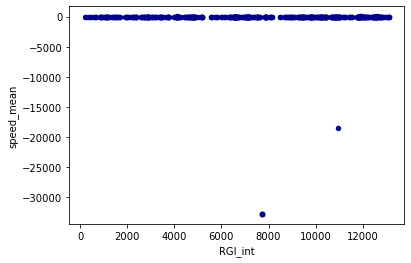

In [104]:
zonal_stats['speed_mean']

fig, ax = plt.subplots()
se_asia_glacier_data.plot.scatter(x='RGI_int',y = 'speed_mean', c = 'darkblue', ax=ax)


In [ ]:
zonal_stats['speed_mean'].min()

In [ ]:
se_asia_glacier_data.plot(column='speed_mean', legend=True)